# Imports

In [1]:
# %matplotlib notebook

In [2]:
!pip install umap-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.ensemble import IsolationForest as IF
from sklearn.manifold import LocallyLinearEmbedding,MDS,Isomap
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

import umap
from ipywidgets import interact

from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, HDBSCAN
from sklearn.mixture import GaussianMixture


https://www.kaggle.com/datasets/ghoshsaibal/creditcard

# Analiza

## Ucitavanje podataka

In [4]:
def csv_to_pd(path):
    return pd.read_csv(path)

def pandas_uniques(df, col_name):
    counts = df[col_name].value_counts()
    unique = df[col_name].unique()
    return unique,counts

def print_uniques(df, cols, count_per_categ=False):
    for c in cols:
        print()
        print(c)
        print("-----------------")
        u, b = pandas_uniques(df,c)
        print("\tVrednosti: ",u)
        print("\tBroj jedinstvenih: ",len(u))
    
        if not count_per_categ: continue
        print("\tJedinstvenih:")
        for i in range(len(b)):
            print("\t",b.iloc[i])

In [5]:
applications = csv_to_pd("./data/application_record.csv")
credits = csv_to_pd("./data/credit_record.csv")

In [6]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',\
        'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']\

print_uniques(applications,cols)


CODE_GENDER
-----------------
	Vrednosti:  ['M' 'F']
	Broj jedinstvenih:  2

FLAG_OWN_CAR
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

FLAG_OWN_REALTY
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

NAME_INCOME_TYPE
-----------------
	Vrednosti:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
	Broj jedinstvenih:  5

NAME_EDUCATION_TYPE
-----------------
	Vrednosti:  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
	Broj jedinstvenih:  5

NAME_FAMILY_STATUS
-----------------
	Vrednosti:  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
	Broj jedinstvenih:  5

NAME_HOUSING_TYPE
-----------------
	Vrednosti:  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
	Broj jedinstvenih:  6

OCCUPATION_TYPE
-----------------
	Vrednosti:  [nan 'Security staff' 'Sales staff' 'Accountants' '

In [8]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [9]:
cols = ['STATUS']
print_uniques(credits,cols)


STATUS
-----------------
	Vrednosti:  ['X' '0' 'C' '1' '2' '3' '4' '5']
	Broj jedinstvenih:  8


## Enkodiranje

In [10]:
def encode_column(df, col_spec):
    df_enc = df.copy()
    for (c, is_one_hot) in col_spec:
        if is_one_hot:
            df_enc = pd.get_dummies(df_enc, columns=[c], dtype=int)
            continue
        le = LabelEncoder()
        le.fit(df_enc[c])
        df_enc[c] = le.transform(df_enc[c])
    return df_enc

def encode_with_dict(df, col, enc_dict):
    df_enc = df.copy()
    df_enc[col] = df_enc[col].apply(lambda x: enc_dict[x])
    return df_enc

In [11]:
cols = [('CODE_GENDER',False),\
        ('FLAG_OWN_CAR',False),\
        ('FLAG_OWN_REALTY',False),\
        ('NAME_INCOME_TYPE',True),\
        ('NAME_EDUCATION_TYPE',False),\
        ('NAME_FAMILY_STATUS', True),\
        ('NAME_HOUSING_TYPE',True),\
        ('OCCUPATION_TYPE',True)]
applications = encode_column(applications, cols)

enc_dict = {'X':-2, 'C':-1, '0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
cred_enc = encode_with_dict(credits, 'STATUS', enc_dict)

## Feature Engineering

In [12]:
applications.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
count,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.0,...,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.328616,0.371897,0.693351,0.427390,1.875243e+05,3.116268,-15997.904649,60563.675328,1.0,...,0.178403,0.004880,0.080918,0.030828,0.007880,0.002374,0.093712,0.004661,0.018226,0.003797
std,5.716370e+05,0.469711,0.483312,0.461103,0.724882,1.100869e+05,1.336736,4185.030007,138767.799647,0.0,...,0.382852,0.069684,0.272709,0.172853,0.088421,0.048663,0.291428,0.068110,0.133767,0.061499
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.610000e+04,0.000000,-25201.000000,-17531.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.609375e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,-19483.000000,-3103.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.047745e+06,0.000000,0.000000,1.000000,0.000000,1.607805e+05,4.000000,-15630.000000,-1467.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.456971e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,-12514.000000,-371.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.999952e+06,1.000000,1.000000,1.000000,19.000000,6.750000e+06,4.000000,-7489.000000,365243.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Podelimo zaradu u grupe 
# 20 - 260k na po 20k, sve preko je jedna grupa
def get_bucket(number, bucket_size, max_value, red_one):
    number = min(number,max_value)
    s = number//bucket_size
    return s - 1 if red_one else s

In [14]:
# Dane od rodjenja, dane zaposljenja prevedemo u godine
applications['DAYS_OLD'] = -applications['DAYS_BIRTH']
applications['DAYS_WORKING'] = applications['DAYS_EMPLOYED'].apply(lambda x: -x if x<0 else 0)
applications['INCOME_BRACKET'] = applications['AMT_INCOME_TOTAL'].apply(lambda x: get_bucket(x,20000,1000000,False))

In [15]:
applications.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1, inplace=True)

In [16]:
applications.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,DAYS_OLD,DAYS_WORKING,INCOME_BRACKET
count,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.0,438557.000000,438557.000000,...,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.328616,0.371897,0.693351,0.427390,1.875243e+05,3.116268,1.0,0.206133,0.287771,...,0.030828,0.007880,0.002374,0.093712,0.004661,0.018226,0.003797,15997.904649,2172.502516,8.881479
std,5.716370e+05,0.469711,0.483312,0.461103,0.724882,1.100869e+05,1.336736,0.0,0.404527,0.452724,...,0.172853,0.088421,0.048663,0.291428,0.068110,0.133767,0.061499,4185.030007,2397.398738,5.013303
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.610000e+04,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7489.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12514.000000,371.000000,6.000000
50%,6.047745e+06,0.000000,0.000000,1.000000,0.000000,1.607805e+05,4.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15630.000000,1467.000000,8.000000
75%,6.456971e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19483.000000,3103.000000,11.000000
max,7.999952e+06,1.000000,1.000000,1.000000,19.000000,6.750000e+06,4.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25201.000000,17531.000000,50.000000


## Outlieri

In [17]:
isf = IF(n_estimators=200, n_jobs=-1)
pred1 = isf.fit_predict(applications)
c = (pred1<0).sum()
print("Outliers: ",c)

Outliers:  20959


In [18]:
lof = LOF(n_neighbors=30, n_jobs=-1)
pred2 = lof.fit_predict(applications)
c = (pred2<0).sum()
print("Outliers: ",c)

Outliers:  31083


In [19]:
outliers=[]
for i in range(len(pred1)):
    if pred1[i]==pred2[i] and pred1[i]==-1:
        outliers.append(i)
print("Outliers: ", len(outliers))

Outliers:  1753


In [20]:
applications.drop(outliers, inplace=True)

## Prikaz

In [21]:
def plot_sub(data, axes, i, j, binwidth, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    ax = get_ax(axes,i,j)

    sns.histplot(data = data, binwidth = binwidth, ax = ax, color=color, legend=False)
    
    ax.axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    ax.axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    ax.axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        ax.set_title(title)

def plot_pie(data, ax,col):
    labels = data.unique()
    counts = data.value_counts()
    ax.pie(counts,labels=labels,autopct='%1.1f%%')
    ax.set_title(col)

def get_ax(axes, i, j):
    if not hasattr(axes,'shape'):
        return axes
    elif len(axes.shape) == 1:
        return axes[i]
    else:
        return axes[i,j]
    
def get_plot_w_h(plot_count):
    w = int(plot_count**0.5)
    h = plot_count //w
    if plot_count%w !=0:
        h+=1
    return w,h

def plot_features(X, col_list, plot_w, plot_h):
    #col_list - kolona, sirina binova, boja
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col, bins, color = col_list[ind]
            plot_sub(X[col], axes, i, j, bins, color)
    plt.tight_layout()
    plt.show()

def plot_pie_charts(X, col_list, plot_w, plot_h):
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col = col_list[ind]
            plot_pie(X[col], get_ax(axes, i, j),col)
    plt.tight_layout()
    plt.show()

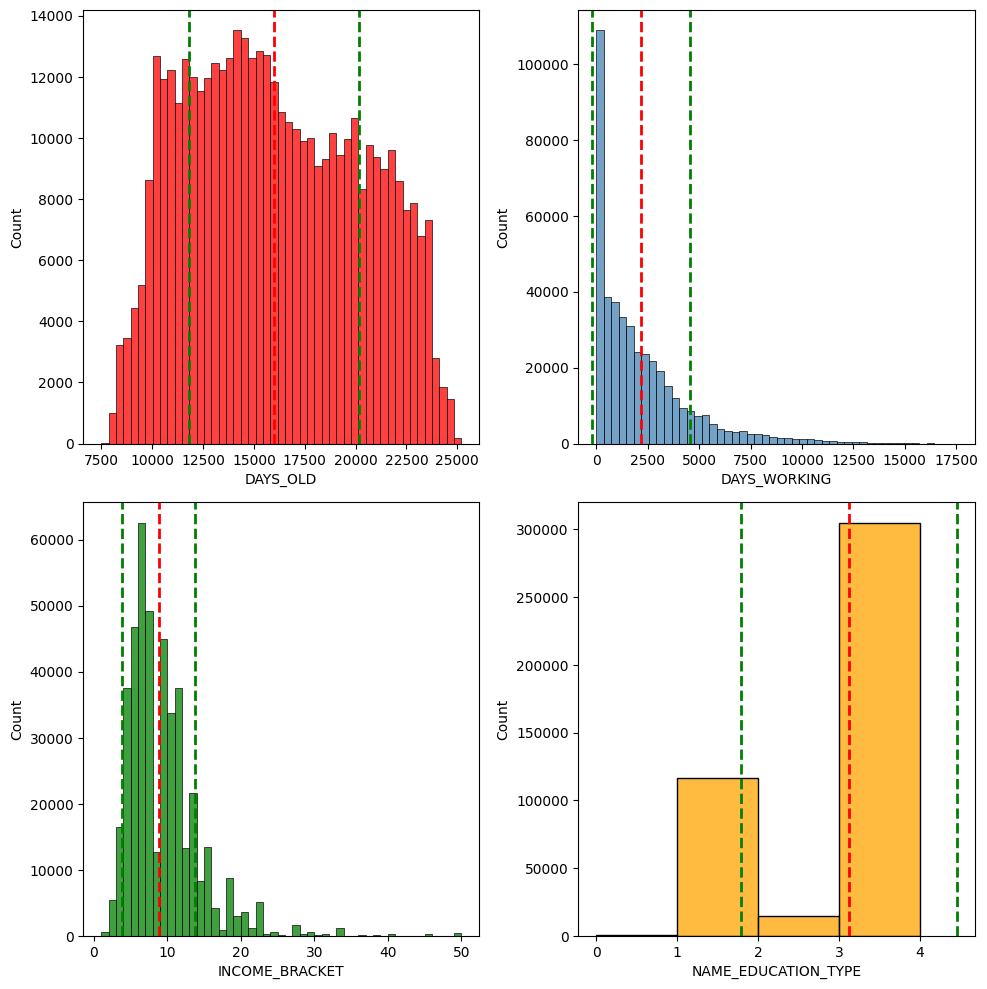

In [22]:
col_list = [('DAYS_OLD',365,'red'),\
            ('DAYS_WORKING',365,'steelblue'),\
            ('INCOME_BRACKET',1,'green'),\
            ('NAME_EDUCATION_TYPE',1,'orange')]
plot_features(applications,col_list,10,10)

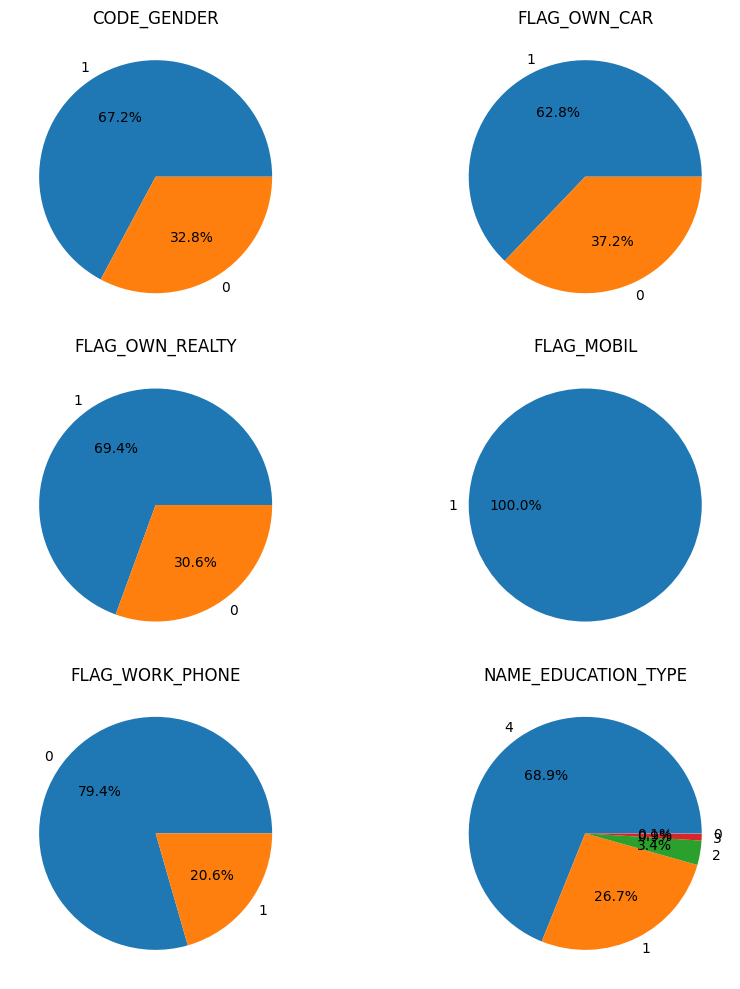

In [23]:
col_list = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_WORK_PHONE','NAME_EDUCATION_TYPE']
plot_pie_charts(applications,col_list,10,10)

# Odredjivanje grupe korisnika

In [24]:
#Nadjemo istoriju placanje za one korisnike ciji ID je u obe tabele
payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
#Za svakog korisnika nadjemo status otplate za svaki od meseca, sortiramo i uzmemo samo najnovije podatke
last_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict()
avg_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)).to_dict()

In [25]:
def get_avg_pay(pay_dict):
    for i in pay_dict.keys():
        l = pay_dict[i]
        tot_w = 0
        s = 0
        for j in range(len(l)):
            w = 1/(j+1)
            s += w * l[j][1]
            tot_w += w
        pay_dict[i] = int(s / tot_w)
    return pay_dict
avg = list(get_avg_pay(avg_pay_dict).values())
last = list(last_pay_dict.values())

In [26]:
ids = list(last_pay_dict.keys())

In [27]:
apps_with_paydata = applications[applications['ID'].isin(ids)]

## Skaliranje

In [28]:
ss = StandardScaler()
apps_with_paydata = ss.fit_transform(apps_with_paydata)

# Redukcija dimenzionalnosti

In [29]:
def get_alg(alg_type, n_components):
    if alg_type=="PCA":
        return PCA(n_components=n_components)
    elif alg_type=="GRP":
        return GaussianRandomProjection(n_components=n_components)
    elif alg_type=="LLE":
        return LocallyLinearEmbedding(n_components=n_components,n_jobs=-1, n_neighbors=10, eigen_solver='dense')
    elif alg_type=="ISO":
        return Isomap(n_components=n_components,n_jobs=-1, n_neighbors=15)
    elif alg_type=="MDS":
        return MDS(n_components=n_components,n_jobs=-1, normalized_stress=False)
    elif alg_type=="UMAP":
        return umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=n_components, n_jobs=-1)
    else:
        print("Unknown algorithm...")
        return PCA(n_components=n_components)
def plot_dict(data):
    df = pd.DataFrame(list(data.items()), columns=['Timestamp', 'Metric'])
    sns.lineplot(x='Timestamp', y='Metric', data=df)
    
def plot_n_comp(data, alg_type, start_comp, end_comp, step, samples=None):
    i = start_comp
    results = {}
    s = time.time()
        
    while i<=end_comp:
        alg = get_alg(alg_type, i)
        s1 = time.time()
        if samples is not None:
            alg.fit(data[:samples])
        else:
            alg.fit(data)
        e1 = time.time()
        rec_loss = 0
        if hasattr(alg, "inverse_transform"):
            transformed = alg.transform(data)
            data_reconstructed = alg.inverse_transform(transformed)
            rec_loss = mean_squared_error(data, data_reconstructed)
        elif hasattr(alg, "reconstruction_error"):
            rec_loss = alg.reconstruction_error()
        elif hasattr(alg, "reconstruction_error_"):
            rec_loss = alg.reconstruction_error_
        elif hasattr(alg, "stress_"):
            rec_loss = alg.stress_
        else:
            print("Unknown dim reduction metric")
        results[i] = abs(rec_loss)
        print(alg_type," - Dimensions: ",i,"\tReconstruction error: ", abs(rec_loss), "\tFit time: ", (e1-s1),"s")
        i+=step
    e = time.time()
    print("Total time: ",(e-s), "s")
    plot_dict(results)

def plot_size_comp(data, n, alg_type, start_size, end_size, step):
    i = start_size
    results = {}
    s = time.time()
        
    while i<=end_size:
        alg = get_alg(alg_type, n)
        s1 = time.time()
        try:
            alg.fit(data[:i])
        except:
            print("No more memory!")
            break

        e1 = time.time()
        rec_loss = 0
        if hasattr(alg, "inverse_transform"):
            transformed = alg.transform(data)
            data_reconstructed = alg.inverse_transform(transformed)
            rec_loss = mean_squared_error(data, data_reconstructed)
        elif hasattr(alg, "reconstruction_error"):
            rec_loss = alg.reconstruction_error()
        elif hasattr(alg, "reconstruction_error_"):
            rec_loss = alg.reconstruction_error_
        elif hasattr(alg, "stress_"):
            rec_loss = alg.stress_
        else:
            print("Unknown dim reduction metric")
        results[i] = abs(rec_loss)
        print(alg_type," - Samples: ",i,"\tReconstruction error: ", abs(rec_loss), "\tFit time: ", (e1-s1),"s")
        i+=step
    e = time.time()
    print("Total time: ",(e-s), "s")
    plot_dict(results)

## PCA

PCA  - Dimensions:  10 	Reconstruction error:  0.6048576830667112 	Fit time:  0.09151005744934082 s
PCA  - Dimensions:  15 	Reconstruction error:  0.49138360407207526 	Fit time:  0.13053679466247559 s
PCA  - Dimensions:  20 	Reconstruction error:  0.3850690359970448 	Fit time:  0.14592528343200684 s
PCA  - Dimensions:  25 	Reconstruction error:  0.2810052549403959 	Fit time:  0.17273926734924316 s
PCA  - Dimensions:  30 	Reconstruction error:  0.18040798364554045 	Fit time:  0.19716525077819824 s
PCA  - Dimensions:  35 	Reconstruction error:  0.0890506982659641 	Fit time:  0.22432208061218262 s
PCA  - Dimensions:  40 	Reconstruction error:  0.01839892016408736 	Fit time:  0.06212615966796875 s
PCA  - Dimensions:  45 	Reconstruction error:  2.8945901856129938e-30 	Fit time:  0.06907320022583008 s
Total time:  1.4341566562652588 s


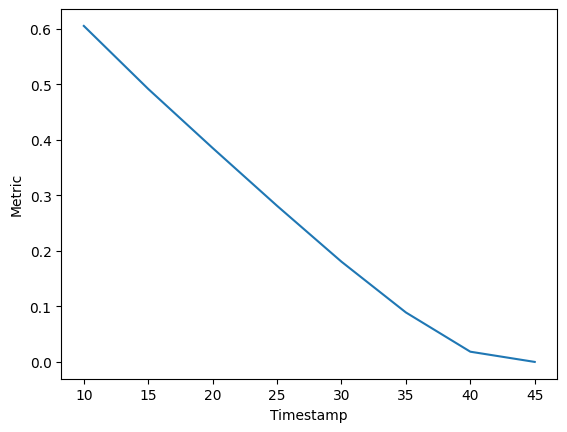

In [30]:
plot_n_comp(apps_with_paydata,"PCA", 10,45,5)

In [31]:
pca = PCA(n_components=40)
pca.fit(apps_with_paydata)
app_train_pca = pca.transform(apps_with_paydata)

## GaussianRandomProjection

GRP  - Dimensions:  10 	Reconstruction error:  0.78439202110458 	Fit time:  0.0 s
GRP  - Dimensions:  15 	Reconstruction error:  0.6688782589027185 	Fit time:  0.003999948501586914 s
GRP  - Dimensions:  20 	Reconstruction error:  0.5865333932707746 	Fit time:  0.0 s
GRP  - Dimensions:  25 	Reconstruction error:  0.4722931251975636 	Fit time:  0.0 s
GRP  - Dimensions:  30 	Reconstruction error:  0.38603482419611646 	Fit time:  0.0029997825622558594 s
GRP  - Dimensions:  35 	Reconstruction error:  0.27851423676059556 	Fit time:  0.0 s
GRP  - Dimensions:  40 	Reconstruction error:  0.17716460733695158 	Fit time:  0.0 s
GRP  - Dimensions:  45 	Reconstruction error:  0.08533660638263918 	Fit time:  0.01564168930053711 s
Total time:  0.2767186164855957 s


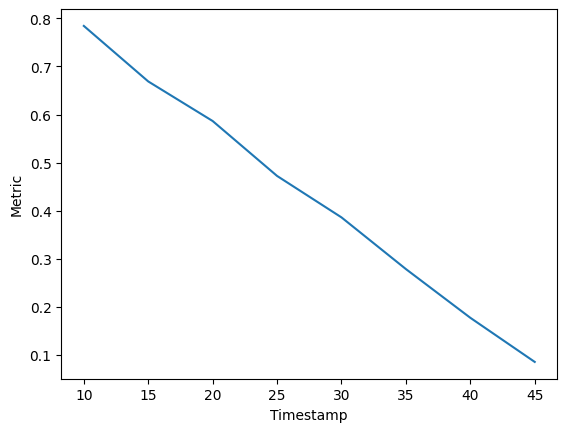

In [32]:
plot_n_comp(apps_with_paydata,"GRP", 10,45,5)

## Locally Linear Embedding

LLE  - Dimensions:  2 	Reconstruction error:  1.335151324998991e-15 	Fit time:  3.070430040359497 s
LLE  - Dimensions:  3 	Reconstruction error:  2.0027269874984864e-15 	Fit time:  3.0432119369506836 s
LLE  - Dimensions:  4 	Reconstruction error:  2.670302649997982e-15 	Fit time:  3.0930416584014893 s
LLE  - Dimensions:  5 	Reconstruction error:  3.3378783124974776e-15 	Fit time:  3.1089894771575928 s
LLE  - Dimensions:  6 	Reconstruction error:  4.005453974996973e-15 	Fit time:  3.120917558670044 s
LLE  - Dimensions:  7 	Reconstruction error:  4.673029637496468e-15 	Fit time:  3.134438991546631 s
LLE  - Dimensions:  8 	Reconstruction error:  5.340605299995964e-15 	Fit time:  3.1267802715301514 s
LLE  - Dimensions:  9 	Reconstruction error:  6.008180962495459e-15 	Fit time:  3.2548091411590576 s
LLE  - Dimensions:  10 	Reconstruction error:  6.6757566249949545e-15 	Fit time:  3.098078727722168 s
LLE  - Dimensions:  11 	Reconstruction error:  7.34333228749445e-15 	Fit time:  3.081397771

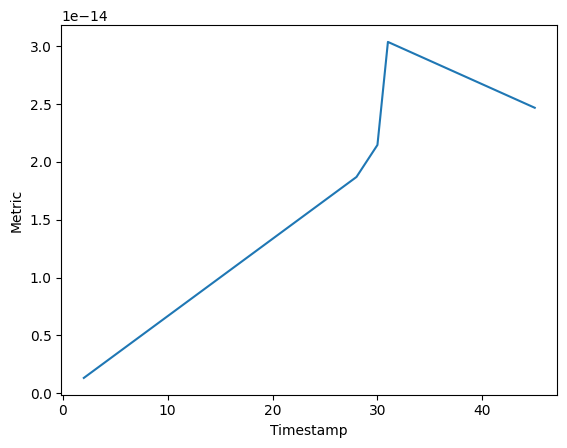

In [33]:
plot_n_comp(apps_with_paydata,"LLE", 2, 45, 1, 3000)

LLE  - Samples:  1000 	Reconstruction error:  1.9834911614695642e-15 	Fit time:  0.4230794906616211 s
LLE  - Samples:  4000 	Reconstruction error:  1.781009159815391e-15 	Fit time:  5.890974521636963 s
LLE  - Samples:  7000 	Reconstruction error:  1.4101558634813143e-15 	Fit time:  22.824429273605347 s
LLE  - Samples:  10000 	Reconstruction error:  4.187567377574251e-15 	Fit time:  58.57434892654419 s
LLE  - Samples:  13000 	Reconstruction error:  1.8221164983179438e-15 	Fit time:  118.77120685577393 s
LLE  - Samples:  16000 	Reconstruction error:  1.3110182679458396e-15 	Fit time:  218.43330645561218 s
Total time:  424.91938495635986 s


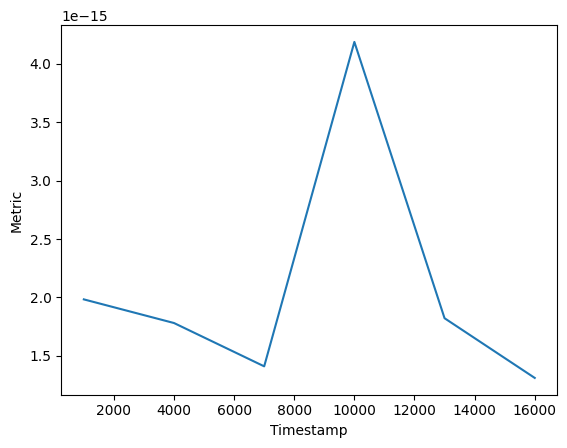

In [34]:
plot_size_comp(apps_with_paydata,2,"LLE",1000,16000,3000)

In [ ]:
LLE = LocallyLinearEmbedding(n_components = 40 ,n_jobs=-1, n_neighbors=20, eigen_solver='dense')
LLE.fit(apps_with_paydata)
print(LLE.reconstruction_error_)

In [ ]:
app_train_lle = LLE.transform(apps_with_paydata)

## Isomap

In [ ]:
plot_n_comp(apps_with_paydata,"ISO", 3, 40, 5, 5000)

## MDS

In [ ]:
plot_n_comp(apps_with_paydata,"MDS", 3,40, 5, 1000)

## UMAP

In [ ]:
plot_n_comp(apps_with_paydata, "UMAP", 2, 40, 1)

# Clusterovanje

## Vizuelizacija

In [ ]:
def transform_with_tsne(data, n_components):
    if n_components>3 or n_components<2:
        print("Bad number of components")
    
    tsne = TSNE(n_components=n_components, n_jobs=-1, verbose = 1, n_iter=1500, perplexity=100, learning_rate=100)
    tsne_res = tsne.fit_transform(data)
    
    return tsne_res
    
def visualise_clusters(data, n_components, labels, title=None):
    fig = plt.figure()
    proj = None if n_components==2 else '3d'
    ax = fig.add_subplot(projection=proj)
    # Scatter plot
    x = data[:,0]
    y = data[:,1]
    z = data[:,2] if n_components==3 else None
    sc = ax.scatter(x, y, z, c=labels, cmap='viridis')  # Adjust size as needed
    cbar = plt.colorbar(sc)
    cbar.set_label('Klasa')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if n_components==3: ax.set_zlabel('Z')
    plt.title('Scatterplot' if title is None else title)
    
    plt.show()

In [ ]:
viz_pca_2d = transform_with_tsne(app_train_pca, 2)

In [ ]:
viz_pca_3d = transform_with_tsne(app_train_pca, 3)

In [ ]:
viz_lle_2d = transform_with_tsne(app_train_lle, 2)
viz_lle_3d = transform_with_tsne(app_train_lle, 3)

In [ ]:
visualise_clusters(viz_pca_2d,2,last)

In [ ]:
visualise_clusters(viz_pca_3d,3,last)

In [ ]:
visualise_clusters(viz_lle_2d,2,last)

In [ ]:
visualise_clusters(viz_lle_3d,3,last)

## Cluster

In [ ]:
#KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, HDBSCAN
#GaussianMixture
def get_all_algs():
    algs = {'KM': KMeans(n_clusters=30, verbose=3), \
            'AC': AgglomerativeClustering(n_clusters=30, compute_distances=True), \
            'HD': HDBSCAN(n_jobs=-1),\
            'GM': GaussianMixture(verbose=3)}
    return algs

def train_algs(data, algs, get_preds=False):
    preds = [] 
    keys = list(algs.keys())
    for key in keys:
        try:
            print(key)
            print("------------------")
            p = algs[key].fit_predict(data)
            if get_preds: preds.append(p)
            print("------------------")
        except Exception as e:
            print(e)
    if get_preds:
        return preds

In [ ]:
algs = get_all_algs()
preds_pca = train_algs(app_train_pca, algs, True)

In [ ]:
algs_lle = get_all_algs()
preds_lle = train_algs(app_train_lle,algs_lle)

## Visualize PCA

In [ ]:
def visualize_all(data, dim, labels, names):
    for i in range(len(labels)):
        visualise_clusters(data,dim,labels[i], names[i])

In [ ]:
visualize_all(viz_pca_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

In [ ]:
visualize_all(viz_pca_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## Visualize LLE

In [ ]:
visualize_all(viz_lle_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

In [ ]:
visualize_all(viz_lle_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## KMeans Tune

In [ ]:
def silhouette_graph(data, min_k, max_k, step):
    rez = {}
    for i in range(min_k,max_k,step):
        km = KMeans(n_clusters=i)
        rez[i] = silhouette_score(data, km.fit_predict(data))
        print("Done: ", i, "/", max_k)
    df = pd.DataFrame(list(rez.items()), columns=['ClusterCount', 'Silhouette'])
    sns.lineplot(x='ClusterCount', y='Silhouette', data=df)

silhouette_graph(app_train_pca, 10, 50, 5)

In [ ]:
silhouette_graph(app_train_lle, 10, 50, 5)

## HDBSCAN

In [ ]:
algs['HD'].labels_.max()

In [ ]:
algs_lle['HD'].labels_.max()

## Agglomerative

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs_lle['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Prediction

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1)

In [ ]:
preds_pca_T = np.transpose(np.array(preds_pca))
preds_lle_T = np.transpose(np.array(preds_lle))

In [ ]:
#preds_pca, preds_lle
#avg, last
k=0.2
test_len = k * len(preds_pca_T)
train_pca, test_pca = preds_pca_T[test_len:], preds_pca_T[:test_len]
train_lle, test_lle = preds_lle_T[test_len:], preds_lle[:test_len]
avg_train, avg_test = avg[test_len:], avg[:test_len] 
last_train, last_test = last[test_len:], last[:test_len] 

In [ ]:
etc.fit(train_pca, avg_train)
print("PCA+AVG: ", etc.score(test_pca,avg_test)

In [ ]:
etc.fit(train_pca, last_train)
print("PCA+LAST: ", etc.score(test_pca,last_test)

In [ ]:
etc.fit(train_lle, avg_train)
print("LLE+AVG: ", etc.score(test_lle,avg_test)

In [ ]:
etc.fit(train_lle, last_train)
print("LLE+LAST: ", etc.score(test_lle,last_test)